In [1]:
import h5py
import numpy as np
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
import sys
import pickle

In [2]:
from opt_einsum import contract

In [3]:
from coherence import *

In [4]:
from importlib import reload

import coherence
reload(coherence)
from coherence import *


In [66]:
%load_ext line_profiler

In [5]:
L_list=np.arange(8,18,2)
# L_list=np.arange(10,14,2)

In [6]:
# dirpath='Data/Bitstring'
# dirpath='/home/jake/Data/Bitstring'
dirpath='.'

In [7]:
f_0={}
for L in L_list:
    f_0[L]=h5py.File(os.path.join(dirpath,f'CT_En2000_pctrl(0.00,1.00,21)_pproj(0.00,0.00,1)_L({L},{L+2},2)_xj(0)_seed0_64_wf.hdf5'))

In [11]:
f_0[8].keys()

<KeysViewHDF5 ['wf_8']>

In [ ]:
save_reduced_dm_swap(f_0,L=8)

In [21]:
save_reduced_dm(f_0,L=10)

100%|██████████| 21/21 [00:01<00:00, 13.54it/s]


In [22]:
save_reduced_dm(f_0,L=12)

100%|██████████| 21/21 [00:13<00:00,  1.55it/s]


In [23]:
save_reduced_dm(f_0,L=14)

100%|██████████| 21/21 [02:19<00:00,  6.66s/it]


In [113]:
wf=f_0[8][f'wf_{8}'][0,0,0,...,:,0]

In [115]:
wf.shape

(2, 2, 2, 2, 2, 2, 2, 2, 2000)

In [117]:
(2**16)**2*8/2**30

32.0

In [143]:
get_rho_av(f_0,8,0,s=0).shape

(2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2)

In [232]:
z=np.mean(np.array([get_reduced_dm(get_rho_av(f_0,8,0,s)) for s in range(2000)],),axis=0)


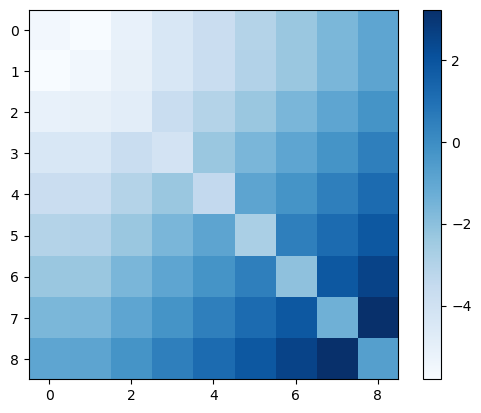

In [233]:
plt.imshow(np.log(z),cmap='Blues')
plt.colorbar()

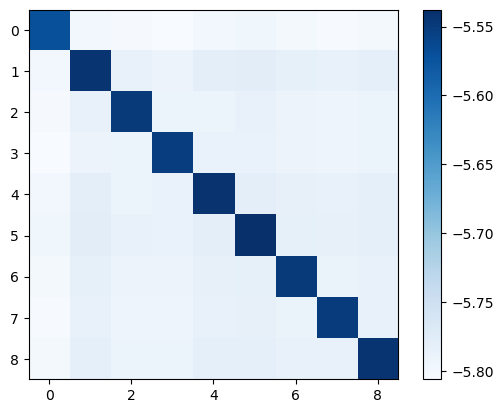

In [234]:
plt.imshow(np.log(get_reduced_dm_per_basis(z)),cmap='Blues',)
plt.colorbar()

In [136]:
z.shape

(2000, 5, 5)

In [ ]:
rho_av={L:get_rho_av(f_0,L,5) for L in [8,10,12,14]}

In [84]:
rho_av={L:get_rho_av(f_0,L,5) for L in [8,10,12,14]}

In [100]:
# rho_av=get_rho_av(f_0,8,10)

In [86]:
# red_dm=get_reduced_dm(rho_av)
red_dm={L:get_reduced_dm(rho_av[L]) for L in [8,10,12,14]}

In [87]:
# red_dm_per=get_reduce_dm_per_state(red_dm)
red_dm_per={L:get_reduce_dm_per_state(red_dm[L]) for L in [8,10,12,14]}

# Plot reduced density matrix

In [ ]:
rho_av={}
for L in L_list:
    with open(f'rho_av_{L}.pickle','rb') as f:
        rho_av[L]=pickle.load(f)

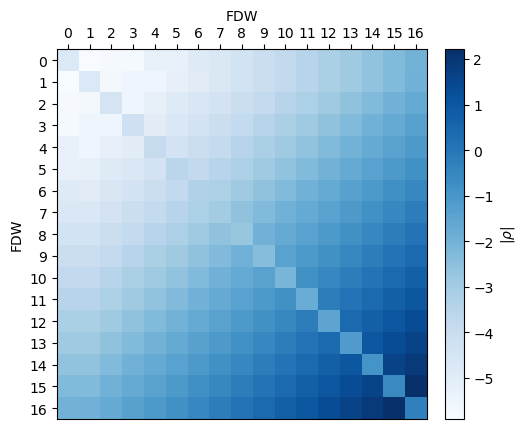

In [6]:
plot_reduced_dm(rho_av[16]['red_dm'][0])

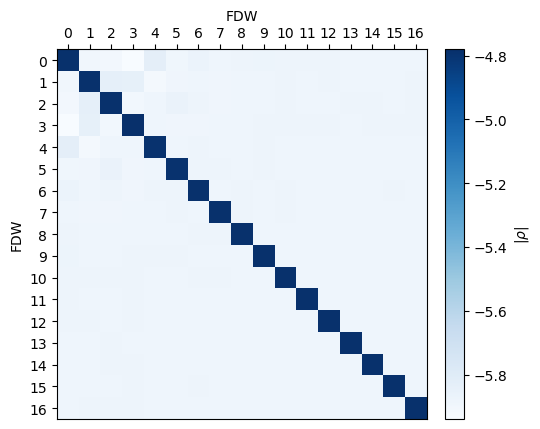

In [81]:
plot_reduced_dm(rho_av[16]['red_dm_per'][0])

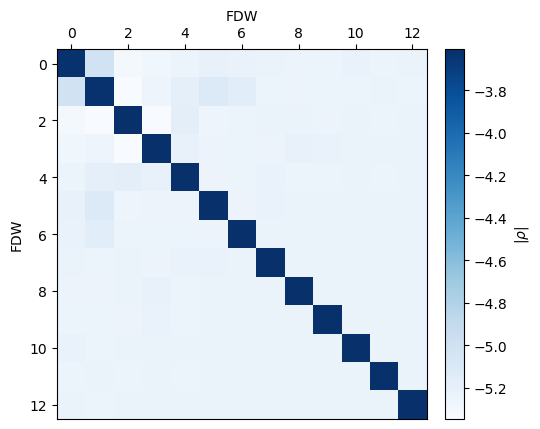

In [20]:
plot_reduced_dm(rho_av[12]['red_dm_per'][0])

# Fit coherence length and decay length

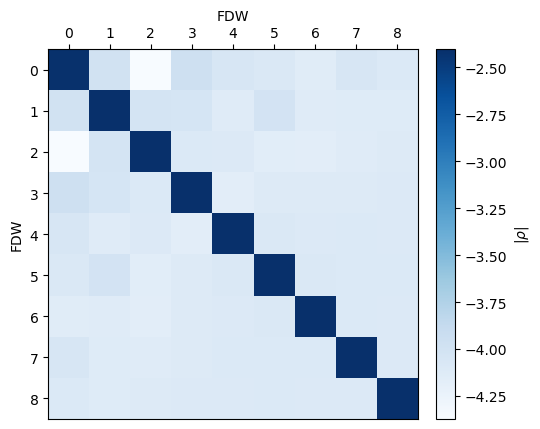

In [7]:
plot_reduced_dm(rho_av[8]['red_dm_per'][0])

In [206]:
def generate_fitting_data(idx,idx_min=1):
    # idx=0
    L_list_=[]
    k_list_=[]
    C_list_=[]
    for L in (L_list):
        k_list=np.arange(idx_min,L+1)
        C=rho_av[L]['red_dm_per'][idx][0,idx_min:]

        L_list_.extend([L]*len(k_list))
        k_list_.extend(k_list)
        C_list_.extend(C)
        # ax.plot(k_list,,'.',label=f'L={L}',color=color)

    L_list_=np.array(L_list_)
    k_list_=np.array(k_list_)
    C_list_=np.array(C_list_)
    return k_list_,L_list_,C_list_

In [200]:
def remove_zero(k_list_,L_list_,C_list_,threshold=1e-10):
    mask= (C_list_>threshold)
    return k_list_[mask],L_list_[mask],C_list_[mask]

In [87]:
import statsmodels.api as sm


In [201]:
def linear_regression_2d(k, L, y):
    # Create the design matrix
    X = np.column_stack((L, k))
    X = sm.add_constant(X)  # Adds a constant term (A) to the model

    # Fit the model
    model = sm.OLS(y, X).fit()

    # Extract the parameters and standard errors
    alpha, beta, A = model.params[1], model.params[2], model.params[0]
    alpha_err, beta_err, A_err = model.bse[1], model.bse[2], model.bse[0]

    return alpha, beta, A, alpha_err, beta_err, A_err

In [221]:
alpha_list=[]
beta_list=[]
A_list=[]
alpha_error_list=[]
beta_error_list=[]
A_error_list=[]

for idx in range(20):
    k_list_,L_list_,C_list_=generate_fitting_data(idx,idx_min=5)
    # print(k_list_.shape,L_list_.shape,C_list_.shape)
    k_list_,L_list_,C_list_=remove_zero(k_list_,L_list_,C_list_)
    try:
        alpha,beta,A,alpha_err, beta_err, A_err=linear_regression_2d(k_list_,L_list_,np.log(C_list_))
    except:
        alpha,beta,A,alpha_err, beta_err, A_err=np.nan,np.nan,np.nan,np.nan,np.nan,np.nan
    alpha_list.append(alpha)
    beta_list.append(beta)
    A_list.append(A)
    alpha_error_list.append(alpha_err)
    beta_error_list.append(beta_err)
    A_error_list.append(A_err)

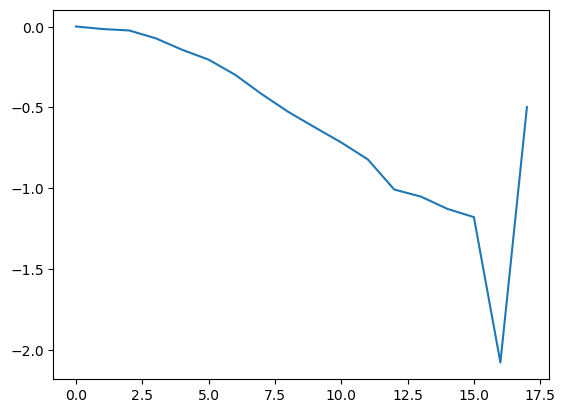

In [223]:
plt.plot(beta_list)

In [44]:
len(C_list_)

60

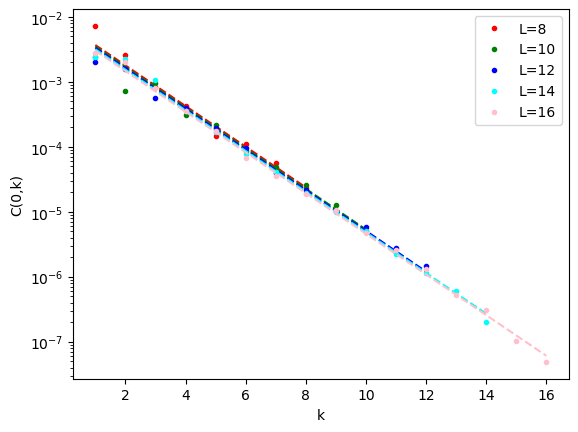

In [211]:
idx=10
color_list=['r','g','b','cyan','pink']
fig,ax=plt.subplots()
for L,color in zip(L_list,color_list):
    k_list=np.arange(1,L+1)
    ax.plot(k_list,rho_av[L]['red_dm_per'][idx][0,1:],'.',label=f'L={L}',color=color)

    ax.plot(k_list,np.exp(A_list[idx])*np.exp(alpha_list[idx]*L)*np.exp(k_list*beta_list[idx]),'--',color=color)
ax.legend()
ax.set_xlabel('k')
ax.set_ylabel('C(0,k)')
ax.set_yscale('log')

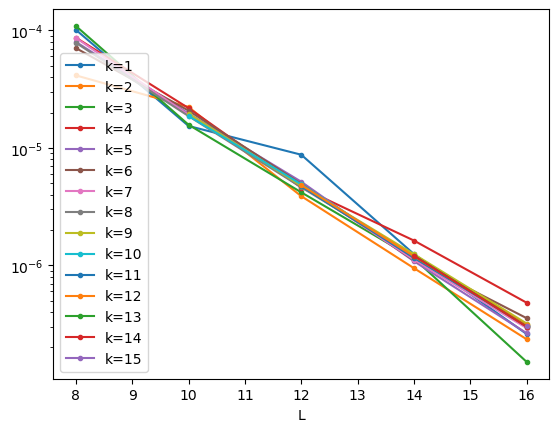

In [27]:
idx=0
C_list_k={}
L_list_k={}
for k in range(1,L_list[-1]):
    C_list_=[]
    L_list_=[]
    for L in L_list:
        try:
            C_list_.append(rho_av[L]['red_dm_per'][idx][0,k])
            L_list_.append(L)
        except:
            pass

    plt.plot(L_list_,C_list_,'.-',label=f'k={k}',)
    C_list_k[k]=C_list_
    L_list_k[k]=L_list_
plt.legend()
plt.xlabel('L')
plt.yscale('log')

In [13]:
def linear_fit(x,y):
    A = np.vstack([x, np.ones(len(x))]).T
    m, c = np.linalg.lstsq(A, y, rcond=None)[0]
    return m,c

In [160]:
np.exp(-5)

0.006737946999085467

In [166]:
linear_fit((L_list_k[1]),np.log(C_list_k[1]))

(-0.722184234346982, -3.4703555223459794)

In [14]:
def average_linear_fit(L_list_k,C_list_k,k_list):
    """return average of slope, and intercept of the first element"""
    intercept_list=[]
    slope_list=[]
    for k in k_list:
        slope,intercept=linear_fit(L_list_k[k],np.log(C_list_k[k]))
        intercept_list.append(intercept)
        slope_list.append(slope)
    return np.mean(slope_list),(intercept_list)[0],

In [15]:
average_linear_fit(L_list_k,C_list_k,np.arange(1,5))

NameError: name 'L_list_k' is not defined

In [16]:
def fit_alpha(idx):
    C_list_k={}
    L_list_k={}
    for k in range(1,L_list[-1]):
        C_list_=[]
        L_list_=[]
        for L in L_list:
            try:
                C_list_.append(rho_av[L]['red_dm_per'][idx][0,k])
                L_list_.append(L)
            except:
                pass

        C_list_k[k]=C_list_
        L_list_k[k]=L_list_
    alpha,A=average_linear_fit(L_list_k,C_list_k,np.arange(1,5))
    return alpha,A

In [17]:
fit_alpha(idx=17)

(0.006993652371882595, -6.119115726008352)

In [18]:
alpha_list=[fit_alpha(idx=idx) for idx in range(18)]

In [19]:
alpha_list=[]
A_list=[]
for idx in range(18):
    alpha,A=fit_alpha(idx=idx)
    alpha_list.append(alpha)
    A_list.append(A)

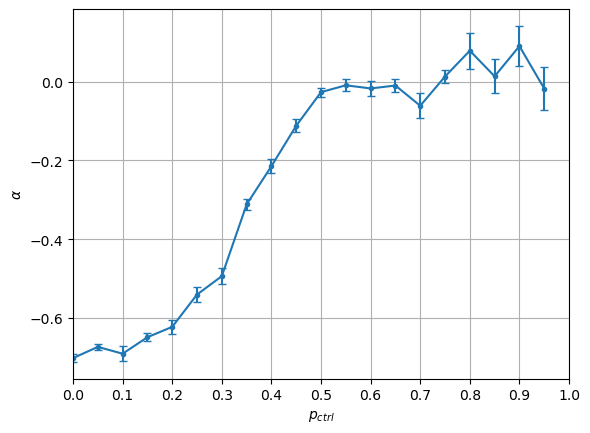

In [109]:
fig,ax=plt.subplots()
p_ctrl_list=np.linspace(0,1,21)
ax.errorbar(p_ctrl_list[:len(alpha_list)],alpha_list,yerr=alpha_error_list,fmt='.-',capsize=3)

ax.set_xlabel('$p_{ctrl}$')
ax.set_ylabel(r'$\alpha$')
ax.set_xlim(0,1)
ax.set_xlim(0,1)
ax.set_xticks(np.linspace(0,1,11))
ax.grid()

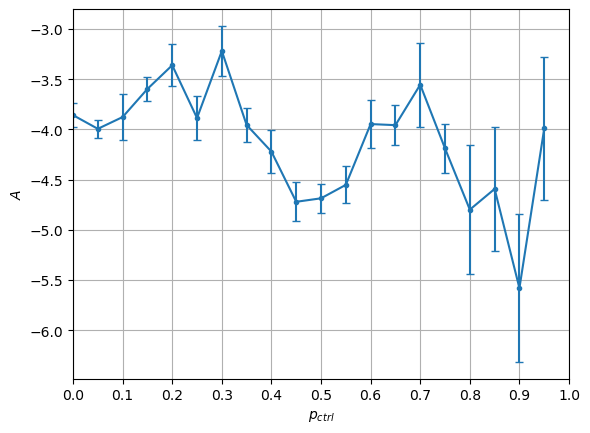

In [108]:
fig,ax=plt.subplots()
p_ctrl_list=np.linspace(0,1,21)
# ax.plot(p_ctrl_list[:len(A_list)],(A_list),'.-')
ax.errorbar(p_ctrl_list[:len(A_list)],A_list,yerr=A_error_list,fmt='.-',capsize=3)

# ax.set_yscale('log')
ax.set_xlabel('$p_{ctrl}$')
ax.set_ylabel(r'$A$')
ax.set_xlim(0,1)
ax.set_xticks(np.linspace(0,1,11))
ax.grid()

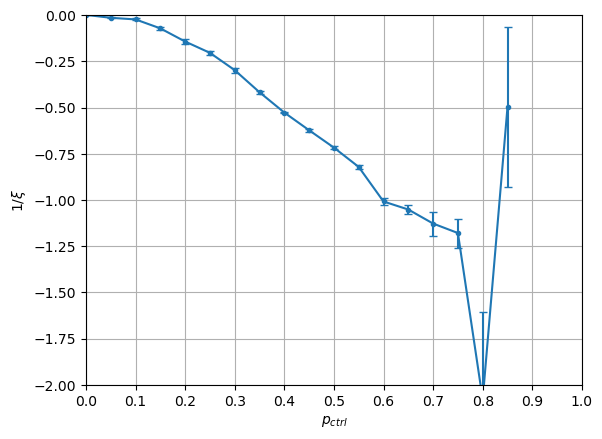

In [225]:
fig,ax=plt.subplots()
p_ctrl_list=np.linspace(0,1,21)
# ax.plot(p_ctrl_list[:len(beta_list)],(beta_list),'.-')
ax.errorbar(p_ctrl_list[:len(beta_list)],beta_list,yerr=beta_error_list,fmt='.-',capsize=3)
# ax.set_yscale('log')
ax.set_xlabel('$p_{ctrl}$')
ax.set_ylabel(r'$1/\xi$')
ax.set_xlim(0,1)
ax.set_ylim(-2,0)
ax.set_xticks(np.linspace(0,1,11))
ax.grid()

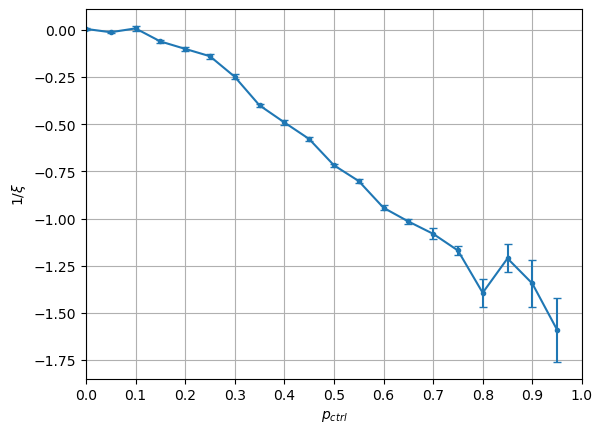

In [106]:
fig,ax=plt.subplots()
p_ctrl_list=np.linspace(0,1,21)
# ax.plot(p_ctrl_list[:len(beta_list)],(beta_list),'.-')
ax.errorbar(p_ctrl_list[:len(beta_list)],beta_list,yerr=beta_error_list,fmt='.-',capsize=3)
# ax.set_yscale('log')
ax.set_xlabel('$p_{ctrl}$')
ax.set_ylabel(r'$1/\xi$')
ax.set_xlim(0,1)
ax.set_xticks(np.linspace(0,1,11))
ax.grid()

In [50]:
linear_regression_2d(k_list_,L_list_,np.log(C_list_))

(-0.7017409621623093, 0.005076766455962539, -3.8582769715536873)

# Plot reduced density matrix (swap order of C and p_m)

In [16]:
C_av={}
for L in L_list[:2]:
    with open(f'C_av_{L}.pickle','rb') as f:
        C_av[L]=pickle.load(f)

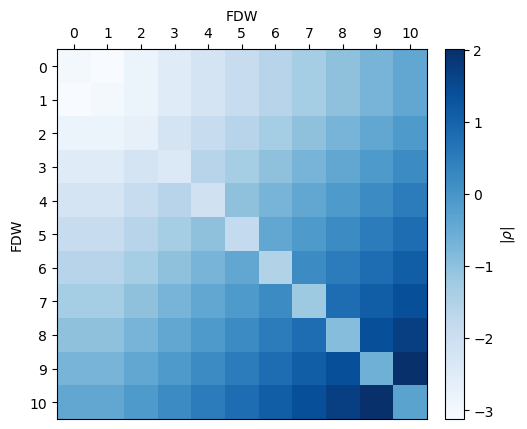

In [35]:
plot_reduced_dm(C_av[10]['red_dm'][0])

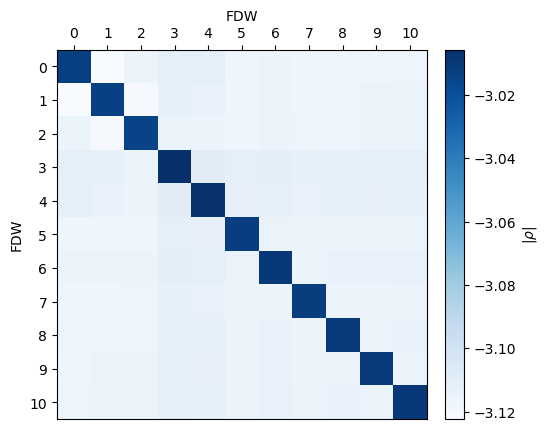

In [36]:
plot_reduced_dm(C_av[10]['red_dm_per'][0])

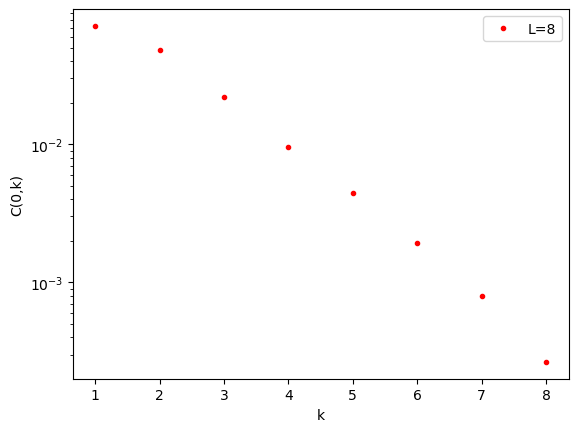

In [289]:
idx=10
color_list=['r','g','b','cyan','pink']
fig,ax=plt.subplots()
for L,color in zip(L_list[:1],color_list):
    k_list=np.arange(1,L+1)
    ax.plot(k_list,C_av[L]['red_dm_per'][idx][0,1:],'.',label=f'L={L}',color=color)

    # ax.plot(k_list,np.exp(A_list[idx])*np.exp(alpha_list[idx]*L)*np.exp(k_list*beta_list[idx]),'--',color=color)
ax.legend()
ax.set_xlabel('k')
ax.set_ylabel('C(0,k)')
ax.set_yscale('log')

# Spread of wave packet (in DW basis)

In [8]:
dirpath='.'

In [9]:
L_list=[8,10]

In [10]:
f_T={}
for L in L_list:
    f_T[L]=h5py.File(os.path.join(dirpath,f'CT_En2000_pctrl(0.00,1.00,21)_pproj(0.00,0.00,1)_L({L},{L+2},2)_xj(0)_seed0_64_wf_T_all.hdf5'))

In [101]:
f_T.keys()

dict_keys([8, 10])

In [106]:
f_T[8]['wf_8'].shape

(21, 1, 129, 2, 2, 2, 2, 2, 2, 2, 2, 2000, 1)

In [195]:
L=10
rho_T=[get_reduced_dm(get_rho_av_T(f_T,L=L,i=19,T=T)) for T in range(1+2*L**2)]

In [196]:
rho_diag=np.array([np.diag(rho) for rho in rho_T])

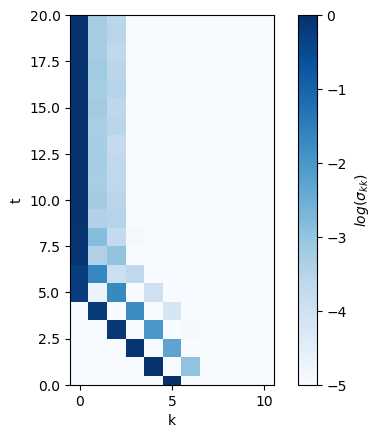

In [197]:
t=20
fig,ax=plt.subplots()
im=ax.imshow(np.log(rho_diag+1e-5),cmap='Blues',vmin=-5)
ax.set_ylim(0,t)
ax.set_ylabel('t')
ax.set_xlabel('k')
plt.colorbar(im,label='$log(\sigma_{kk})$')

In [184]:
rho_T_per=np.array([get_reduced_dm_per_basis(rho) for rho in rho_T])

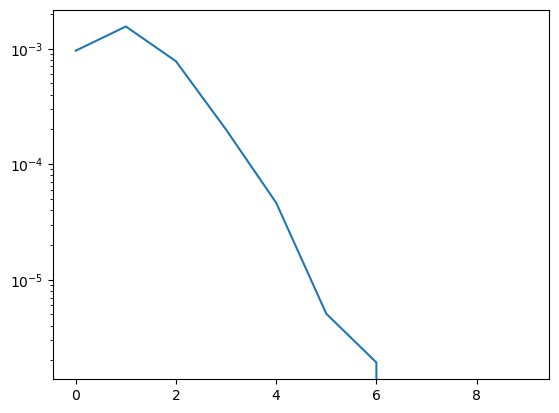

In [185]:
plt.plot(rho_T_per[187,0,1:])
plt.yscale('log')

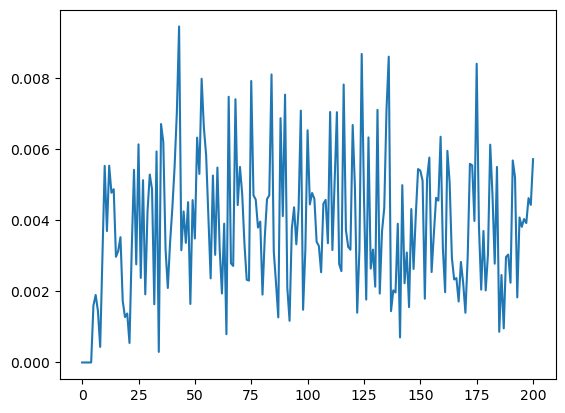

In [186]:
plt.plot(rho_T_per[:,0,1])

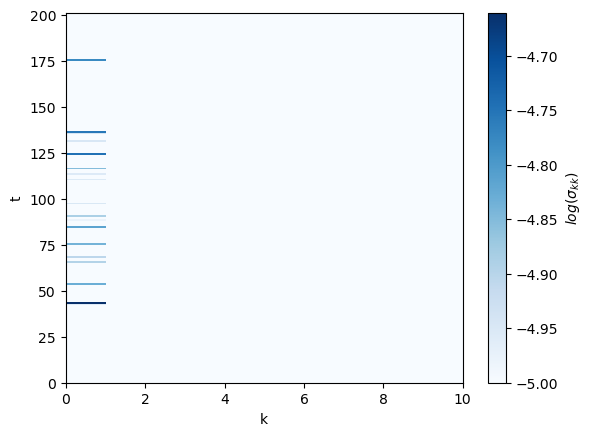

In [187]:
t=201
fig,ax=plt.subplots()
im=ax.pcolormesh(np.log(rho_T_per[:,0,1:]+1e-5),cmap='Blues',vmin=-5)
ax.set_ylim(0,t)
ax.set_ylabel('t')
ax.set_xlabel('k')
plt.colorbar(im,label='$log(\sigma_{kk})$')

In [69]:
rho_diag[6]

array([0.0078181 , 0.00782172, 0.01584085, 0.03215851, 0.0613126 ,
       0.12975232, 0.24992275, 0.49537325, 0.        ])

In [46]:
L_list_k

{1: [8, 10, 12, 14, 16],
 2: [8, 10, 12, 14, 16],
 3: [8, 10, 12, 14, 16],
 4: [8, 10, 12, 14, 16],
 5: [8, 10, 12, 14, 16],
 6: [8, 10, 12, 14, 16],
 7: [8, 10, 12, 14, 16],
 8: [8, 10, 12, 14, 16],
 9: [10, 12, 14, 16],
 10: [10, 12, 14, 16],
 11: [12, 14, 16],
 12: [12, 14, 16],
 13: [14, 16],
 14: [14, 16],
 15: [16]}

In [29]:
C_list_k

{1: [0.0001014375576271923,
  1.5372278657255204e-05,
  8.74518892962681e-06,
  1.2468850017422317e-06,
  2.6016473530358407e-07],
 2: [4.1461930937973094e-05,
  2.229900662654719e-05,
  3.882851043166184e-06,
  9.460973340649982e-07,
  2.34619921757807e-07],
 3: [0.0001092518724660655,
  1.575064934135284e-05,
  4.185446628838931e-06,
  1.1439006466601082e-06,
  1.5059828298762385e-07],
 4: [8.694676117497654e-05,
  2.180974528666167e-05,
  4.597001921292447e-06,
  1.6254069299631878e-06,
  4.804093157501973e-07],
 5: [8.000548122580502e-05,
  1.961125431172607e-05,
  5.151117564603396e-06,
  1.0843429814437376e-06,
  2.644243587323471e-07],
 6: [7.08501057534389e-05,
  2.0773486251119718e-05,
  4.939085609219586e-06,
  1.1015791539525591e-06,
  3.549185982482388e-07],
 7: [8.6659687041884e-05,
  1.9094849761406152e-05,
  4.791235694796206e-06,
  1.1168592494964182e-06,
  2.921291199889824e-07],
 8: [7.860385363562394e-05,
  1.8658656732254638e-05,
  4.62177684077718e-06,
  1.19831826

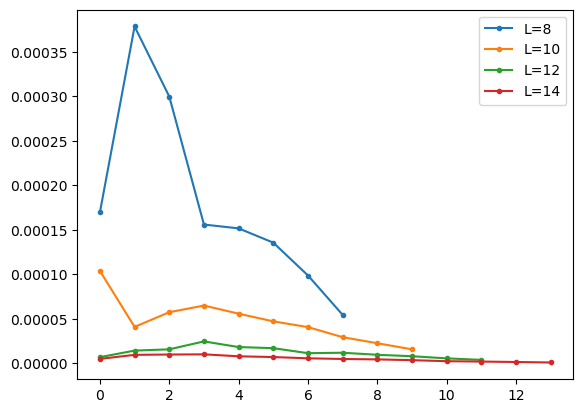

In [27]:
for L in [8,10,12,14]:
    plt.plot(rho_av[L]['red_dm_per'][5][0,1:],'.-',label=f'L={L}',)
plt.legend()

In [ ]:
for L in [8,10,12,14]:
    plt.plot([red_dm_per[L][i,i+1] for i in range(L)],'.-',label=f'L={L}')

/tmp/ipykernel_4182577/1813485167.py:4: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string ".-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(red_dm_per[L][0,1:],'.-',label=f'L={L}',ls='dashed')


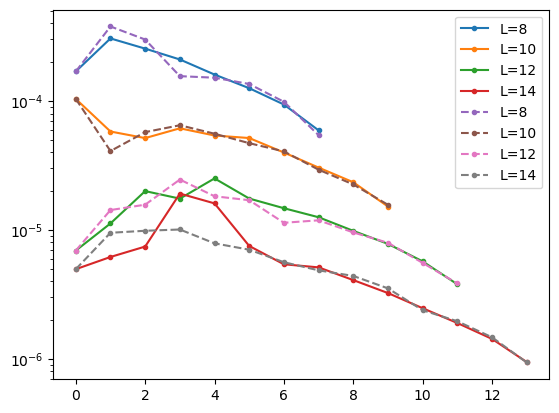

In [88]:
for L in [8,10,12,14]:
    plt.plot([red_dm_per[L][i,i+1] for i in range(L)],'.-',label=f'L={L}')
for L in [8,10,12,14]:
    plt.plot(red_dm_per[L][0,1:],'.-',label=f'L={L}',ls='dashed')
plt.legend()
plt.yscale('log')   
# plt.xscale('log')   

/tmp/ipykernel_4182577/1033578318.py:2: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string ".-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(red_dm_per[L][4,:4],'.-',label=f'L={L}',ls='dashed')


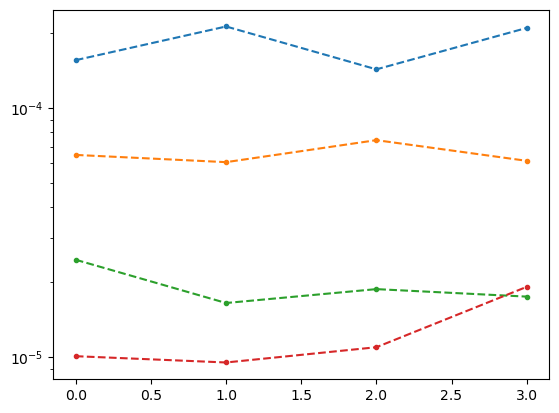

In [92]:
for L in [8,10,12,14]:
    plt.plot(red_dm_per[L][4,:4],'.-',label=f'L={L}',ls='dashed')
plt.yscale('log')

/tmp/ipykernel_4182577/2565562905.py:4: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string ".-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(red_dm_per[L][0,1:],'.-',label=f'L={L}',ls='dashed')


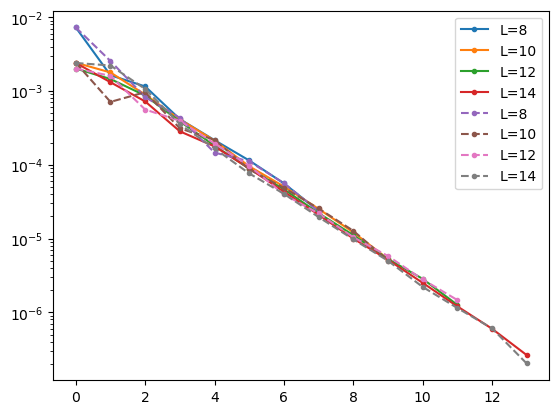

In [80]:
for L in [8,10,12,14]:
    plt.plot([red_dm_per[L][i,i+1] for i in range(L)],'.-',label=f'L={L}')
for L in [8,10,12,14]:
    plt.plot(red_dm_per[L][0,1:],'.-',label=f'L={L}',ls='dashed')
# plt.plot(red_dm_per[0,1:],'.-')
plt.legend()
plt.yscale('log')   
# plt.xscale('log')   

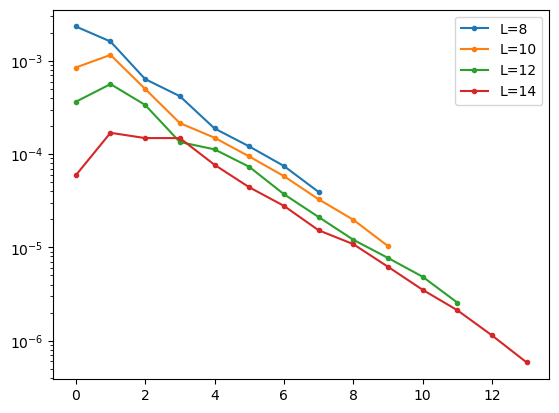

In [60]:
for L in [8,10,12,14]:
    plt.plot(red_dm_per[L][0,1:],'.-',label=f'L={L}')
# plt.plot(red_dm_per[0,1:],'.-')
plt.yscale('log')
plt.legend()

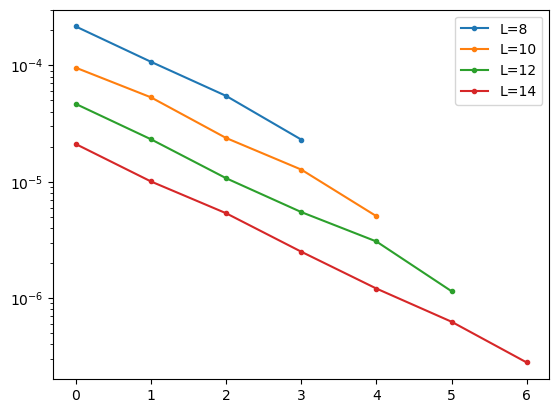

In [36]:
for L in [8,10,12,14]:
    plt.plot(red_dm_per[L][L//2,L//2+1:],'.-',label=f'L={L}')
# plt.plot(red_dm_per[0,1:],'.-')
plt.yscale('log')
plt.legend()

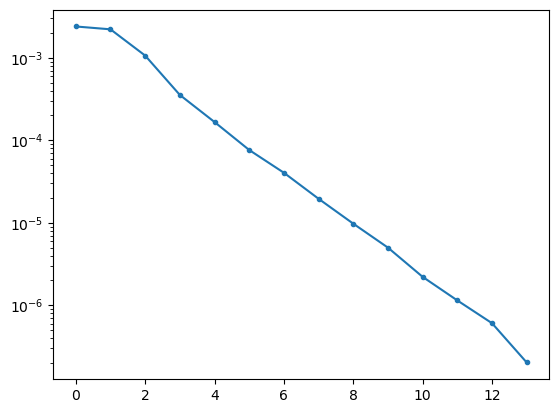

In [306]:
plt.plot(red_dm_per[0,1:],'.-')
plt.yscale('log')

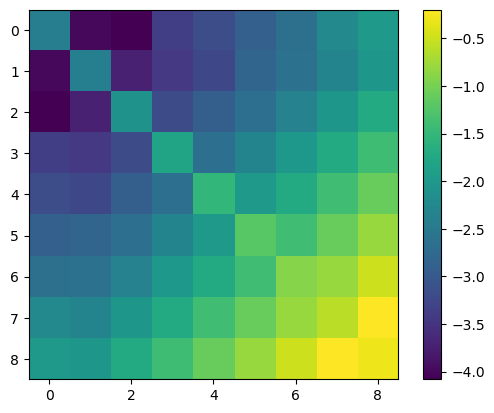

In [93]:
plt.imshow(np.log10(red_dm))
plt.colorbar()

In [ ]:
plt.imshow(np.log10(red_dm_per))
plt.colorbar()

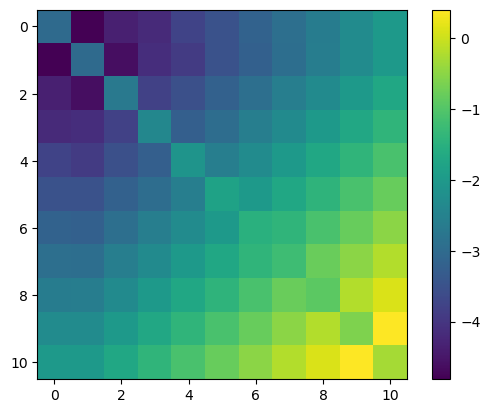

In [ ]:
plt.imshow(np.log10(red_dm))
plt.colorbar()

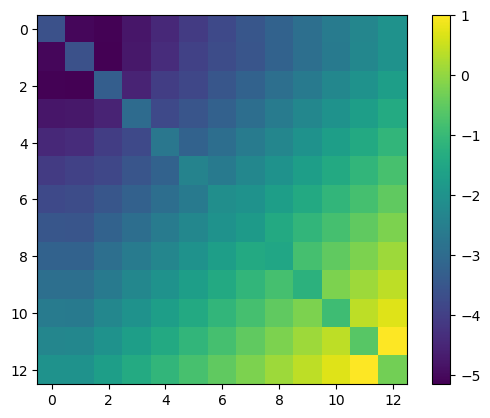

In [57]:
plt.imshow(np.log10(red_dm))
plt.colorbar()

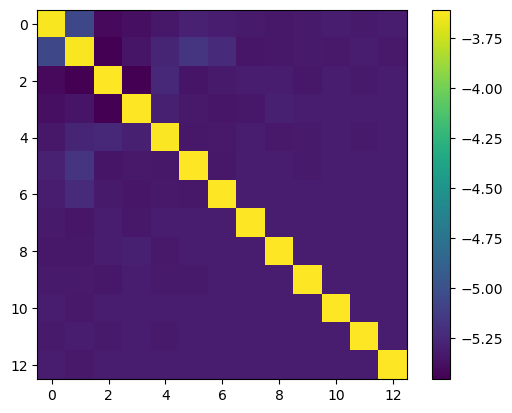

In [82]:
plt.imshow(np.log10(red_dm_per))
plt.colorbar()

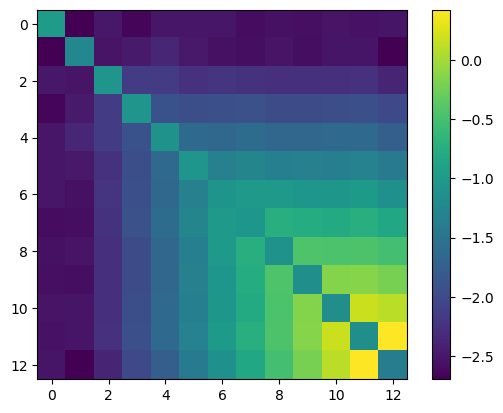

In [86]:
plt.imshow(np.log10(red_dm))
plt.colorbar()

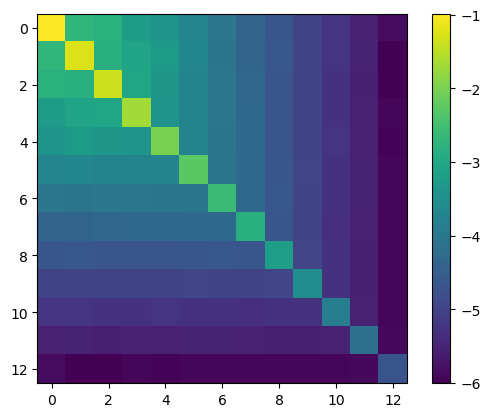

In [87]:
plt.imshow(np.log10(red_dm_per))
plt.colorbar()

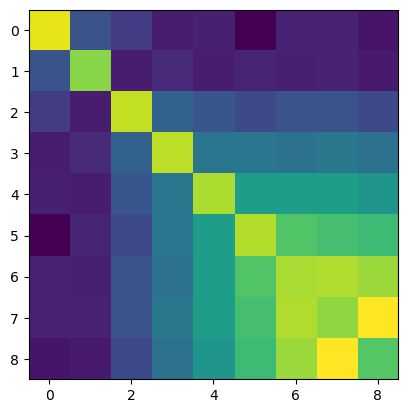

In [40]:
plt.imshow(np.log10(red_dm))

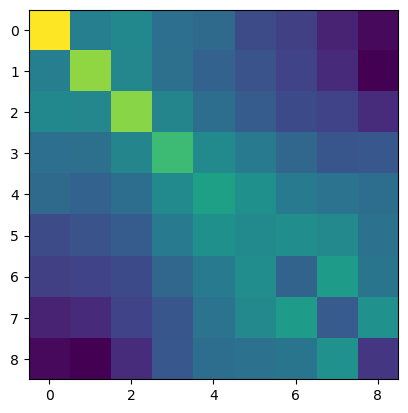

In [44]:
plt.imshow(np.log10(red_dm))

In [22]:
l1_coherence_2(rho_av,0,1)

0.00010143755762719205

In [13]:
l1_coherence_2(rho_av,1,1)

0.003915372962018893

In [14]:
l1_coherence_2(rho_av,0,1,)

0.00010143755762719205

In [15]:
rho_av.reshape((2**1,2**1))[:4,:4]

ValueError: cannot reshape array of size 65536 into shape (4096,4096)

In [14]:
sys.getsizeof(rho_av)/2**10/2**10

128.00045776367188

In [16]:
l1_coherence_2(rho_av,0,0)

0.0038090870155051016

In [17]:
l1_coherence_2(rho_av,1,1)

0.003915372962018893

In [18]:
l1_coherence_2(rho_av,0,1)

0.00010143755762719205

In [19]:
l1_coherence_2(rho_av,1,2)

0.00018960059500231185

In [43]:
L=10
list(range(L))+[2*L]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 20]

In [83]:
with open('C_av_8.pickle','rb') as f:
    z=pickle.load(f)

In [84]:
z['red_dm'].shape

(21, 9, 9)

In [77]:
with open('C_av_8_tt.pickle','rb') as f:
    zz=pickle.load(f)

In [79]:
zz['red_dm'].shape

(21, 9, 9)

In [18]:
(2**14)**2*8/2**20

2048.0

In [41]:
(2**18)**2*16/2**30

1024.0

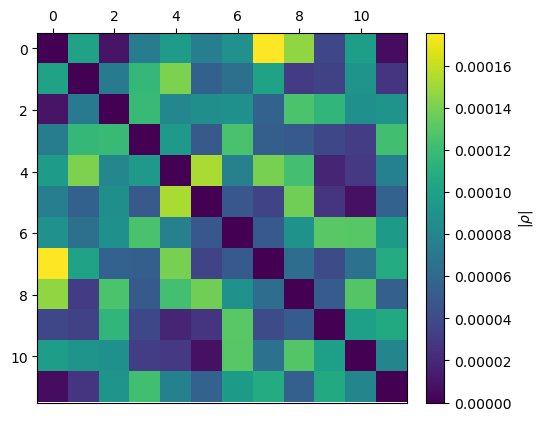

In [14]:
plot_coherence(rho_av,diag=False)

In [15]:
def l1_coherence_all(f_0,L,i,normalization=False,average=True):
    # wf=f_0[L][f'wf_{L}'][i,0,0,...,:,0]
    # dm_av=np.einsum(wf,np.r_[np.arange(0,L),2*L],np.conj(wf),np.r_[np.arange(L,2*L),2*L],np.arange(2*L))/f_0[L][f'wf_{L}'].shape[-2]

    rho_av=get_rho_av(f_0,L,i)
    
    return [l1_coherence(rho_av,k,normalization=normalization,average=average) for k in range(L)]

In [54]:
l1_coherence_all(f_0,L=8,i=0,normalization=True)

[0.013131993423792317,
 0.016200700609301462,
 0.027189298844675493,
 0.045647250896196916,
 0.1082025774614713,
 0.22065050694901078,
 0.4268802372429756,
 0.8443569274743464]

In [28]:
coh_map8=[l1_coherence_all(f_0,L=8,i=i,normalization=False,average=True) for i in range(21)]

In [25]:
coh_map10=[l1_coherence_all(f_0,L=10,i=i,normalization=False,average=True) for i in range(21)]

In [21]:
coh_map12=[]
for i in tqdm(range(21)):
    coh_map12.append(l1_coherence_all(f_0,L=12,i=i,normalization=False,average=True))
coh_map12=np.array(coh_map12)


100%|██████████| 21/21 [09:50<00:00, 28.12s/it]


In [35]:
coh_map8_raw=[l1_coherence_all(f_0,L=8,i=i,normalization=False,average=False) for i in range(21)]

In [19]:
%lprun -f get_rho_av l1_coherence_all(f_0,L=12,i=0,normalization=False,average=True)

Timer unit: 1e-09 s

Total time: 28.2637 s
File: /tmp/ipykernel_4158687/1750786917.py
Function: get_rho_av at line 1

Line #      Hits         Time  Per Hit   % Time  Line Contents
     1                                           def get_rho_av(f_0,L,i):
     2         1  160627808.0 160627808.0      0.6      wf=f_0[L][f'wf_{L}'][i,0,0,...,:,0]
     3         1 28103111385.0 28103111385.0     99.4      rho_av=np.einsum(wf,np.r_[np.arange(0,L),2*L],np.conj(wf),np.r_[np.arange(L,2*L),2*L],np.arange(2*L))/f_0[L][f'wf_{L}'].shape[-2]
     4         1        380.0    380.0      0.0      return rho_av

In [23]:
%lprun -f get_rho_av l1_coherence_all(f_0,L=14,i=0,normalization=False,average=True)

Timer unit: 1e-09 s

Total time: 448.278 s
File: /tmp/ipykernel_4158687/1750786917.py
Function: get_rho_av at line 1

Line #      Hits         Time  Per Hit   % Time  Line Contents
     1                                           def get_rho_av(f_0,L,i):
     2         1  547838140.0 547838140.0      0.1      wf=f_0[L][f'wf_{L}'][i,0,0,...,:,0]
     3         1 447730345438.0 447730345438.0     99.9      rho_av=np.einsum(wf,np.r_[np.arange(0,L),2*L],np.conj(wf),np.r_[np.arange(L,2*L),2*L],np.arange(2*L))/f_0[L][f'wf_{L}'].shape[-2]
     4         1        471.0    471.0      0.0      return rho_av

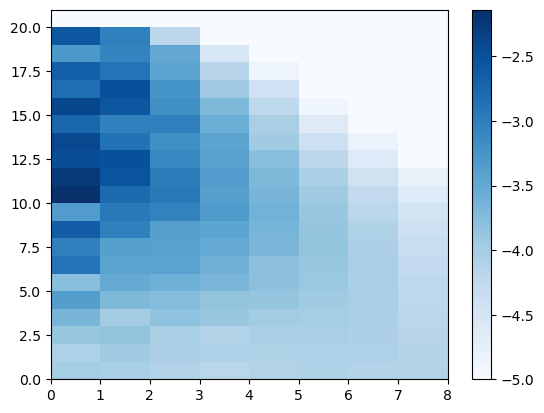

In [34]:
plt.pcolormesh(np.log10(np.array(coh_map8)+1e-10),vmin=-5,cmap='Blues')
plt.colorbar()

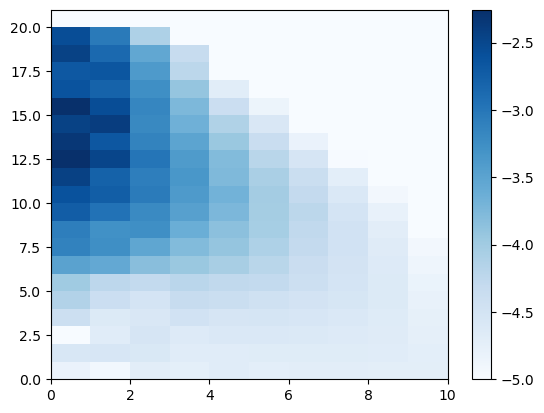

In [33]:
plt.pcolormesh(np.log10(np.array(coh_map10)+1e-10),vmin=-5,cmap='Blues')
plt.colorbar()

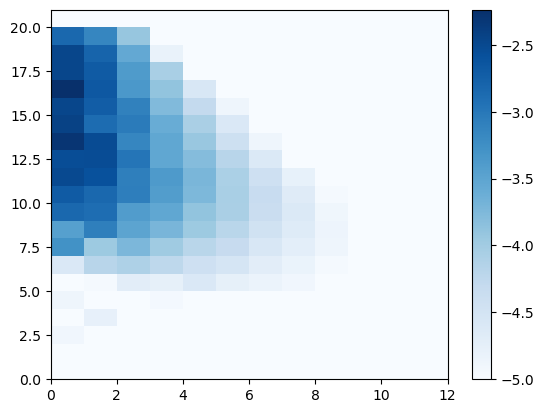

In [32]:
plt.pcolormesh(np.log10(np.array(coh_map12)+1e-10),vmin=-5,cmap='Blues')
plt.colorbar()

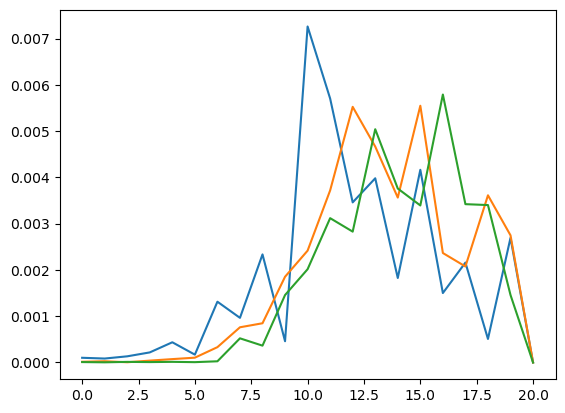

In [30]:
plt.plot(np.array(coh_map8)[:,0])
plt.plot(np.array(coh_map10)[:,0])
plt.plot(np.array(coh_map12)[:,0])

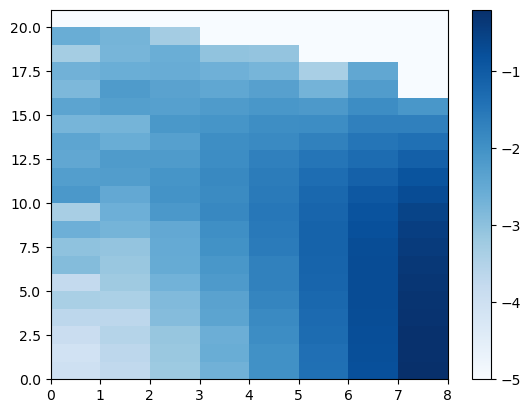

In [38]:
plt.pcolormesh(np.log10(np.array(coh_map8_raw)+1e-10),vmin=-5,cmap='Blues')
plt.colorbar()